In [1]:
# %% libraries

import torch
import datetime as dt

import numpy as np
import matplotlib.pyplot as plt

# local imports
import os
_FILE_DIR = os.path.abspath("")  
_MODEL_DIR = os.path.dirname(_FILE_DIR)
os.chdir(_MODEL_DIR)
import fdl21.data.prototyping_metrics as pm
import ws_optimization.sw_dataset as swd
import fdl21.data.filterbanks as fb

# 1. Get 1D signal from dataloader

In [2]:
# %% 1D signal from dataloader 

data_load = swd.SolarWindDataset(dir_path = 'C:/Users/jkobayashi/gh_repos/idea-lab-sw-isax/sw-data/nasaomnireader/1999')
signal_1d = data_load.__getitem__(10)
signal_1d

tensor([493.4000, 502.6000, 461.1000,  ..., 444.7000, 444.2000, 439.2000])

# 2. Apply fourier transform using PyTorch FFT

(should return 1D tensor)

In [3]:
 # %% Fourier transform 

sig_fft = torch.fft.fft(signal_1d)# - torch.mean(signal_1d))
# print(sig_fft)
sig_fft = torch.real(sig_fft)
# print(sig_fft)
print(sig_fft.shape)

torch.Size([44640])


# 3. Create a 1D tensor with frequencies of triangle apexes

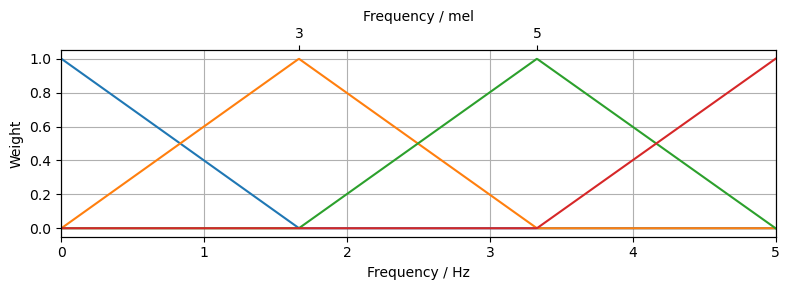

In [4]:
# %% Filterbanks (from local filterbank module)

fbank = fb.filterbank(restore_from_file='C:/Users/jkobayashi/gh_repos/idea-lab-sw-isax/data/filterbanks/fb_0.01_1.66_3.33_5.0_DC_HF.pkl')
fbank.visualize_filterbank()

In [5]:
# %% Tensors of matrix and frequencies

mat = torch.tensor(fbank.fb_matrix)     # 2D tensor of filterbank matrix (triangles)
freq = torch.tensor(fbank.fftfreq)      # 1D tensor of frequencies

# 4. Create a 2D that will hold the filtered spectrum for each filter
 (Dimensions = n_filters x length(fourier_spectrum))

In [6]:
all_filtered_signals = torch.empty(mat.shape[0], signal_1d.shape[0])
all_filtered_signals

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

# 5. Loop over apexes

Multiply triangle frequencies and multiply by fourier spectrum

Place result in 2D repository tensor

Inverse Fourier transform on each row and add to get original signal

In [7]:
sample_freq = torch.fft.fftfreq(signal_1d.shape[0],d=1/6000)
total_sig = torch.zeros(signal_1d.shape[0])
for i,bank in enumerate(mat):
    filter = np.interp(np.abs(sample_freq),freq,bank,left=None,right=None,period=None)
    filteredYF = sig_fft.clone()
    filteredYF = filteredYF*filter

    filtered_sig = torch.real(torch.fft.ifft(filteredYF))

    all_filtered_signals[i] = filtered_sig
    total_sig += filtered_sig

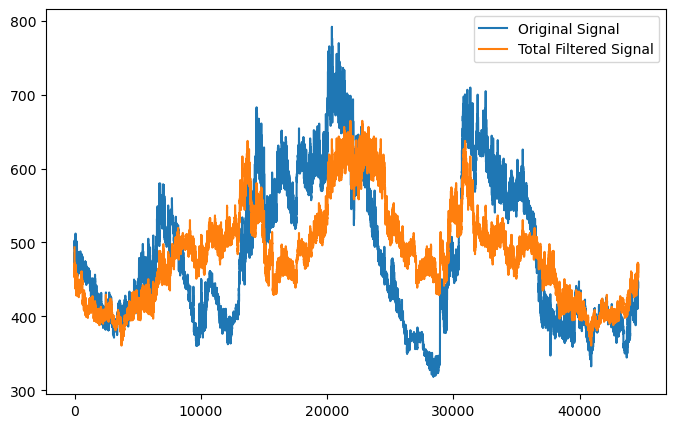

In [8]:
fig, axes = plt.subplots(figsize=(8,5))
axes.plot(signal_1d,label='Original Signal')
axes.plot(total_sig,label='Total Filtered Signal')
axes.legend()
plt.show()